# Problem 2

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Load libraries used throughout the problem set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

In [2]:
import pandas as pd
import numpy as np

def draw_samples(n=10000, mean=0, variance=1):
    """Draws 'n' samples from a normal distribution with specified mean and variance, and returns a pandas dataframe."""
    # Drawing samples
    samples = np.random.randn(n) * np.sqrt(variance) + mean
    # Storing in a dataframe
    df = pd.DataFrame(samples, columns=['Value'])
    return df

# Using the function
df = draw_samples()
print(df)

# Optionally: save to a CSV
# df_sa

         Value
0    -1.267810
1     0.103770
2     0.712923
3     1.950855
4    -0.218045
...        ...
9995 -0.406528
9996 -1.698147
9997  1.407334
9998 -0.586699
9999 -0.943318

[10000 rows x 1 columns]


In [6]:
df['i-z'] = df['Value'] + 1
df['Absolute_Value'] = df['i-z'].abs()
df['Log_Absolute_Value'] = np.log(df['Absolute_Value'])
print(df)
print(df.describe())

         Value       i-z  Absolute_Value  Log_Absolute_Value
0    -1.063084 -0.063084        0.063084           -2.763289
1     0.465779  1.465779        1.465779            0.382387
2     1.113196  2.113196        2.113196            0.748201
3    -0.599478  0.400522        0.400522           -0.914987
4    -0.394835  0.605165        0.605165           -0.502254
...        ...       ...             ...                 ...
9995 -0.533218  0.466782        0.466782           -0.761894
9996  0.956806  1.956806        1.956806            0.671313
9997 -1.111562 -0.111562        0.111562           -2.193172
9998  0.056917  1.056917        1.056917            0.055356
9999 -0.705992  0.294008        0.294008           -1.224148

[10000 rows x 4 columns]
              Value           i-z  Absolute_Value  Log_Absolute_Value
count  10000.000000  10000.000000    10000.000000        10000.000000
mean      -0.002935      0.997065        1.165875           -0.210159
std        1.006597      1.00659

# ARCH Process for Problem 2.2

In [13]:
class ARCH1():

    def __init__(self, α, pi, ω, x0=0, T=1000, dist='Gaussian', v=6, seed=None):
        """
        A class to simulate and visualize an ARCH(1) process.
    
        Methods:
        simulate(): Simulate the ARCH(1) process.
        plot_results(): Plot simulated data (returns and vol), histogram+density and QQ plot
        plot_tail_comparison(): Plot simulated data for ARCH(1) process and another process y, as well as QQ plots for both.
        """
        # Set seed if supplied to replicate results
        if seed is not None:
            np.random.seed(seed)
        
        # Assign parameters
        self.α         = α    # Coefficient for the ARCH(1) process
        self.ω         = ω    # Constant term for the ARCH(1) process. Default is 1.
        self.pi        = pi   # 
        self.T         = T    # Number of time periods for the simulation. Default is 1000.
        self.x0        = x0   # Initial value for the process. Default is 0.
        self.dist      = dist # Distribution to use for random variables ('Gaussian' or 't'). Default is 'Gaussian'.
        self.v         = v    # Degrees of freedom for the t-distribution (if used). Default is 6.
        
        # Assign x and σ2 processes
        self.x         = np.empty(T) 
        self.sigma2    = np.empty(T)
        
        # Choose which distribution to draw the errors from.
        if self.dist == "Gaussian":
            self.z = np.random.normal(size=self.T)
        elif self.dist == "t":
            if self.v > 2:  # Ensure that degrees of freedom is greater than 2 for scaling
                scale_factor = np.sqrt((self.v-2) / self.v) # Scale such that mean is 0 and var is 1
                self.z = np.random.standard_t(df=self.v, size=self.T) * scale_factor
            else:
                raise ValueError("Degrees of freedom must be greater than 2 for scaling. (Cauchy case not implemented here)")
        else:
            raise ValueError("Invalid distribution. Use 'Gaussian' or 't'.")
    
    
    def simulate(self):
        for t in range(self.T):
            if t == 0: # For t=0 we use the initial value x0 in the cond. var process to initialize.
                self.sigma2[t] = self.ω + self.α*self.x0**2
                self.x[t]      = np.sqrt(self.sigma2[t])*self.z[t]
            else: # Else we use x_t-1
                self.sigma2[t] = self.ω + self.α*self.x[t-1]**2
                self.x[t]      =(1-self.pi) * self.x[t-1] + np.sqrt(self.sigma2[t])*self.z[t]

        return self.x, self.sigma2

    
    def plot_results(self, figsize=(13, 13)):
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs[0, 0].plot(self.x, lw=0.5, label="ARCH(1) process")
        axs[0, 0].legend()
        axs[0, 1].plot(self.sigma2, lw=0.5, label="Conditional Variance")
        axs[0, 1].legend()
        sns.histplot(self.x, stat="density", bins=int(self.T / 25), kde=True, label='Data', ax=axs[1, 0])
        sns.lineplot(x=self.x, y=norm.pdf(self.x, self.x.mean(), self.x.std()), color='red', label=f'N(s={self.x.std():.2f})', ax=axs[1, 0])
        sm.qqplot(self.x, line='q', fit=True, label='ARCH(1) - QQ plot', ax=axs[1, 1])
        axs[1, 1].legend()
        plt.suptitle(f"Alpha = {self.α}, Pi = {self.pi}", y=0.91)  # y refers to spacing between suptitle and figures
        plt.legend()
        plt.show()

    def plot_process(self, figsize=(13, 13)):
        plt.plot(self.x, lw=0.5, label="ARCH(1) process")
        
    def plot_tail_comparison(self, y, figsize=(13, 5)):
        fig2, axs2 = plt.subplots(1, 3, figsize=figsize)
        axs2[0].plot(self.x, lw=0.3, label="ARCH(1) process")
        axs2[0].plot(y, lw=0.3, label="iid N(0,V) process")
        axs2[0].legend()
        sm.qqplot(self.x, line='q', fit=True, label='ARCH(1) - QQ plot', ax=axs2[1])
        axs2[1].legend()
        sm.qqplot(y, line='q', fit=True, label='iid N(0,V)', ax=axs2[2])
        axs2[2].legend()
        plt.show()

Estimates are given by with std. errors and t_vals in ():

phi_bar_est= 0.901421296462886, ( se(.)=0.07182136236120729, t_val= 12.550879944735895 )

omega_est= 47.664599932661915, ( se(.)=8.618364650412293, t_val= 5.530585194069468 )

alpha_est= 0.18591273412577303, ( se(.)=0.04983055783670401, t_val= 3.7308981114563022 )


/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

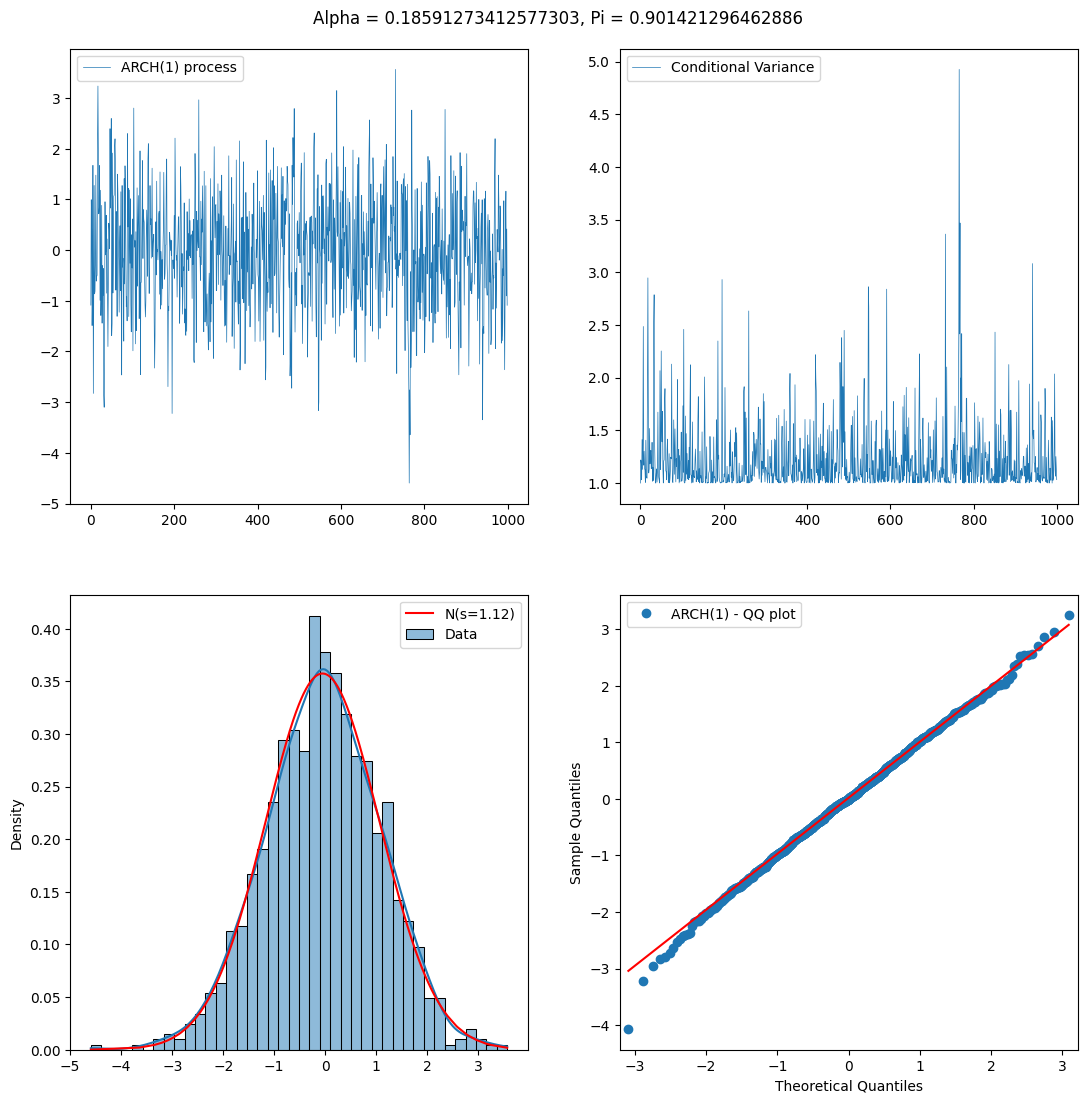

/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

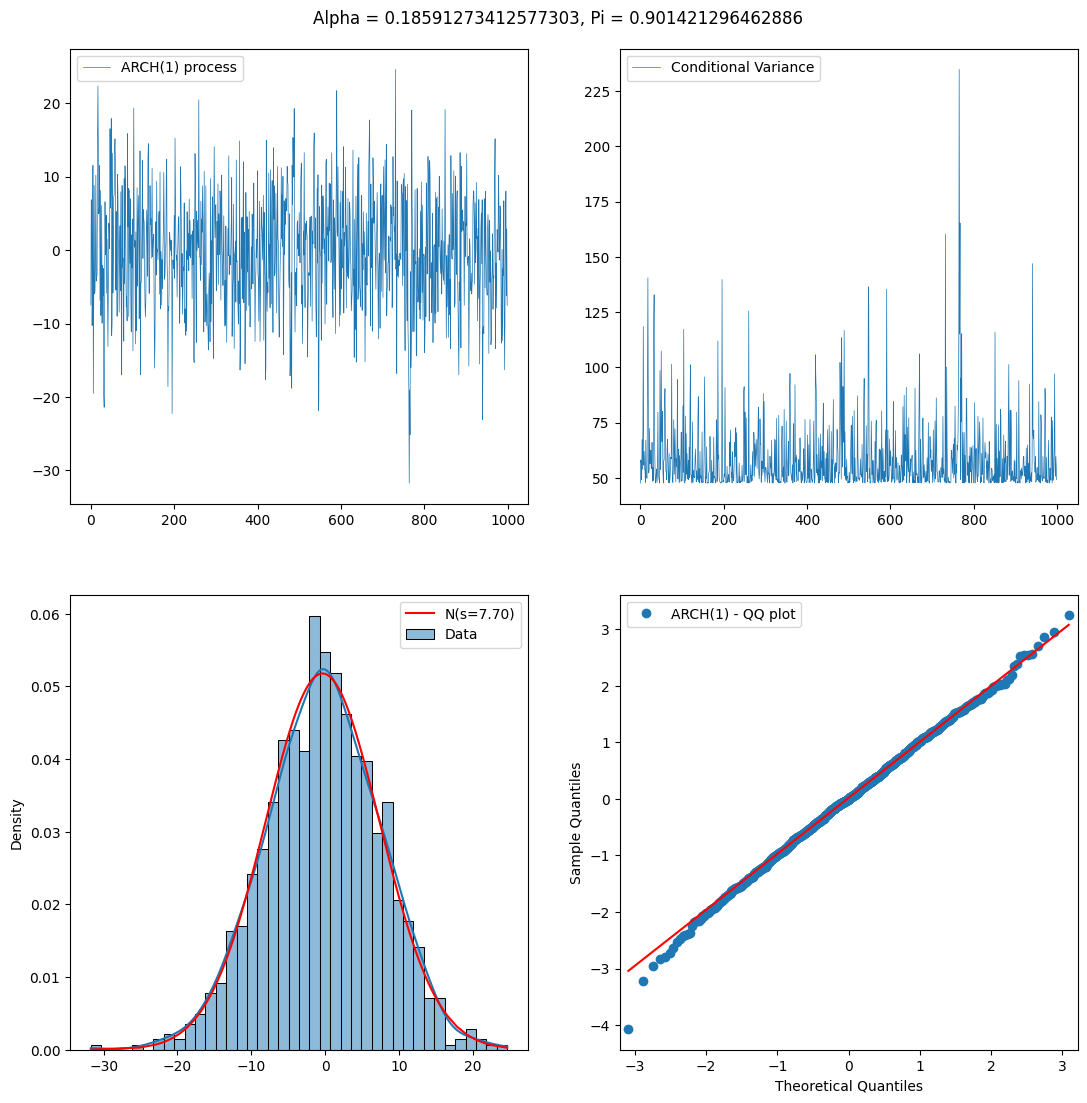

In [14]:
arch00 = ARCH1(α=0.18591273412577303, pi=0.901421296462886,ω=1, seed=123)
arch00.simulate()
arch00.plot_results()
# arch00.plot_process(figsize=(14,14))
# arch10 = ARCH1(α=1.0, pi=0.0, seed=123)
# arch10.simulate()
# arch10.plot_process(figsize=(14,14))
# arch01 = ARCH1(α=0.0, pi=1.0, seed=123)
# arch01.simulate()
# arch01.plot_process(figsize=(14,14))
# arch11 = ARCH1(α=1.0, pi=1.0, seed=123)
# arch11.simulate()
# arch11.plot_process(figsize=(14,14))
arch01 = ARCH1(α=0.18591273412577303, pi=0.901421296462886, ω=47.664599932661915, seed=123)
arch01.simulate()
arch01.plot_results()


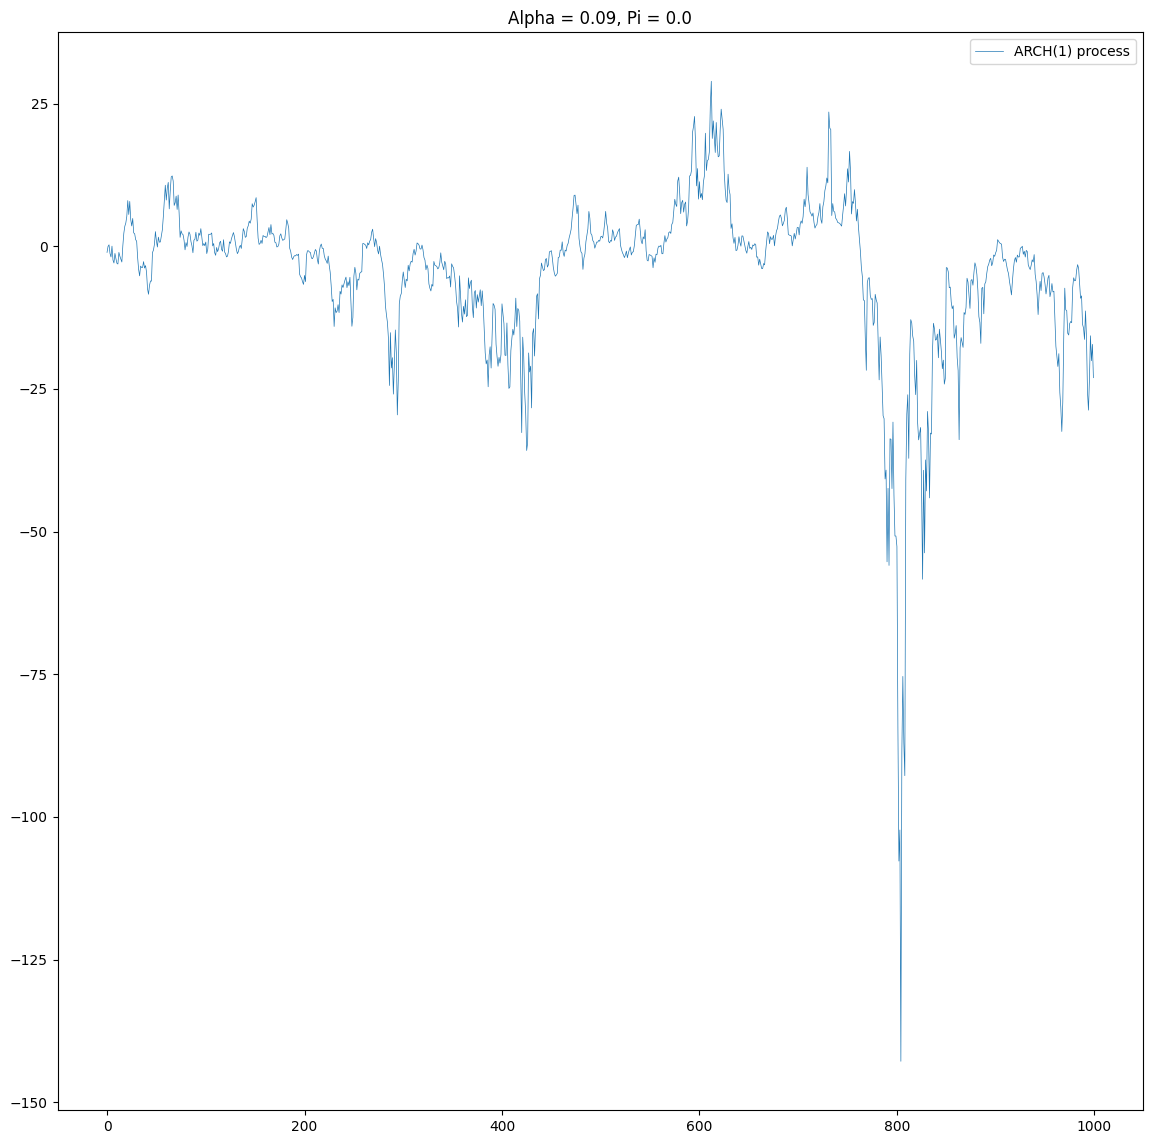

KeyboardInterrupt: 

In [5]:
from IPython.display import display, clear_output
import time

# Set the range for α values
alphas = np.arange(0, 1.01, 0.01)

# Loop for real-time animation of the ARCH process for each α value
for alpha in alphas:
    # Create an ARCH instance, simulate and plot
    arch = ARCH1(α=alpha, pi=0.0, seed=123)
    arch.simulate()
    
    # Display the plot
    fig, ax = plt.subplots(figsize=(14,14))
    ax.plot(arch.x, lw=0.5, label="ARCH(1) process")
    ax.set_title(f"Alpha = {alpha:.2f}, Pi = 0.0")
    ax.legend()
    plt.show()
    
    # Pause for a short duration and then clear the output to display the next plot
    time.sleep(0.1)
    clear_output(wait=True)


In [12]:
from IPython.display import display, clear_output
import time
import imageio
# Modify the plot_process() function to save the plots with filenames based on the α value
def modified_plot_process(self, filename=None, figsize=(7, 7)):
    if filename is None:
        filename = f"/home/august/code/jupyter/econometrics/class/pics/Alpha_01_{self.α:.2f}.png"
    
    plt.figure(figsize=figsize)
    plt.plot(self.x, lw=0.5, label="ARCH(1) process")
    plt.suptitle(f"Alpha = {self.α:.2f}, Pi = {self.pi}", y=0.91)
    plt.legend()
    plt.savefig(filename)
    plt.close()

# Update the method in the class
ARCH1.plot_process = modified_plot_process

# Run the simulation and save the plots for each α value in the desired range
alphas = np.arange(0, 1.01, 0.001)
saved_files = []
for alpha in alphas:
    arch = ARCH1(α=alpha, pi=1, seed=123)
    arch.simulate()
    filename = f"/home/august/code/jupyter/econometrics/class/pics/Alpha_1_{alpha:.2f}.png"
    arch.plot_process(filename=filename)
    saved_files.append(filename)
 # Display the first 5 paths to verify


# Create a GIF from the saved plots
gif_filename = "/home/august/code/jupyter/econometrics/class/pics/arch_animation-1.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.1) as writer:
    for filename in saved_files:
        image = imageio.imread(filename)
        writer.append_data(image)

gif_filename  # Return the path to the saved GIF for verification


/tmp/ipykernel_169108/4085578674.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'/home/august/code/jupyter/econometrics/class/pics/arch_animation-1.gif'

In [5]:
from IPython.display import display, clear_output
import time
import imageio
# Modify the plot_process() function to plot multiple pi values on the same plot
alphas = np.arange(0, 1.001, 0.001)
def modified_plot_multiple_pi(self, pis, filename=None, figsize=(7, 7)):
    if filename is None:
        filename = f"/home/august/code/jupyter/Econometrics/class/pics/Alpha_MultiPi_{self.α:.3f}.png"
    
    plt.figure(figsize=figsize)
    
    # Loop through pis and simulate and plot for each pi
    for pi_val in pis:
        arch = ARCH1(α=self.α, pi=pi_val, seed=123)
        arch.simulate()
        plt.plot(arch.x, lw=0.5, label=f"ARCH(1) process, Pi = {pi_val}")
    
    plt.suptitle(f"Alpha = {self.α:.3f}")
    plt.legend()
    plt.savefig(filename)
    plt.close()

# Update the method in the class
ARCH1.plot_process = modified_plot_multiple_pi

# Pi values to consider
pis = [0]

# Run the simulation and save the plots for each α value
saved_files = []
for alpha in alphas:
    arch = ARCH1(α=alpha, pi=1, seed=123)  # We just need an ARCH instance for alpha, pi is varied inside the modified function
    filename = f"/home/august/code/jupyter/Econometrics/class/pics/Alpha_MultiPi_{alpha:.3f}.png"
    arch.plot_process(pis=pis, filename=filename)
    saved_files.append(filename)

# Note: Please ensure the directory paths are correct and accessible on your local machine.

# Code to create the GIF remains the same
gif_filename = "/home/august/code/jupyter/Econometrics/class/pics/Assignment 1.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.01) as writer:
    for filename in saved_files:
        image = imageio.imread(filename)
        writer.append_data(image)

gif_filename


/tmp/ipykernel_7219/4112957597.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'/home/august/code/jupyter/Econometrics/class/pics/Assignment 1.gif'

In [4]:

# Code to create the GIF remains the same
gif_filename = "/home/august/code/jupyter/Econometrics/class/pics/ARCH_assignment1.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.01) as writer:
    for filename in saved_files:
        image = imageio.imread(filename)
        writer.append_data(image)

gif_filename

/tmp/ipykernel_7219/2606729710.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'/home/august/code/jupyter/Econometrics/class/pics/ARCH_assignment1.gif'

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
alphas = np.arange(0, 1.001, 0.001)
# Assuming the ARCH1 class and its methods are defined elsewhere in your code
# I'm going to focus on the modified_plot_multiple_pi function

def modified_plot_log_multiple_pi(self, pis, filename=None, figsize=(7, 7)):
    if filename is None:
        filename = f"/home/august/code/jupyter/econometrics/class/pics/Alpha_Log_MultiPi_{self.α:.2f}.png"
    
    plt.figure(figsize=figsize)
    
    # Loop through pis and simulate and plot for each pi
    for pi_val in pis:
        arch = ARCH1(α=self.α, pi=pi_val, seed=123)
        arch.simulate()
        plt.plot(np.log(arch.x + 1e-10), lw=0.5, label=f"Log ARCH(1) process, Pi = {pi_val}")  # Added np.log and a small value to prevent log(0)
    
    plt.suptitle(f"Log Values for Alpha = {self.α:.3f}")
    plt.legend()
    plt.savefig(filename)
    plt.close()

# Update the method in the class
ARCH1.plot_process = modified_plot_log_multiple_pi

# Pi values to consider
pis = [ 0]

# Run the simulation and save the plots for each α value
saved_files = []
for alpha in alphas:
    arch = ARCH1(α=alpha, pi=1, seed=123)  # We just need an ARCH instance for alpha, pi is varied inside the modified function
    filename = f"/home/august/code/jupyter/econometrics/class/pics/Alpha_Log_MultiPi_{alpha:.3f}.png"
    arch.plot_process(pis=pis, filename=filename)
    saved_files.append(filename)

# Note: Please ensure the directory paths are correct and accessible on your local machine.

# Code to create the GIF remains the same
gif_filename = "/home/august/code/jupyter/econometrics/class/pics/arch_log_animation_multi_pi.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.05) as writer:
    for filename in saved_files:
        image = imageio.imread(filename)
        writer.append_data(image)

gif_filename


/tmp/ipykernel_169108/2979504712.py:18: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(arch.x + 1e-10), lw=0.5, label=f"Log ARCH(1) process, Pi = {pi_val}")  # Added np.log and a small value to prevent log(0)
/tmp/ipykernel_169108/2979504712.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


'/home/august/code/jupyter/econometrics/class/pics/arch_log_animation_multi_pi.gif'